[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jguan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


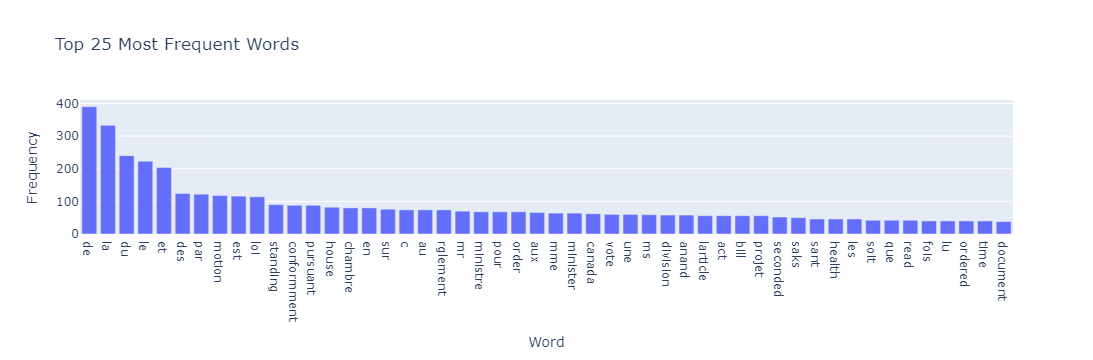

In [1]:
import PyPDF2
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
import pandas as pd
import plotly.express as px

# Download NLTK stopwords
nltk.download('stopwords')

# Load the PDF
pdf_file = 'Journal331.pdf'
with open(pdf_file, 'rb') as file:
    reader = PyPDF2.PdfReader(file)
    text = ""
    for page in reader.pages:
        text += page.extract_text()

# Text cleaning
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

cleaned_text = clean_text(text)

# Count word frequency
word_counts = Counter(cleaned_text.split())

# Convert to DataFrame
df_word_counts = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])

# Sort by frequency and get top 25 words
df_top_words = df_word_counts.sort_values(by='Frequency', ascending=False).head(50)


# Create a Plotly bar chart
fig = px.bar(df_top_words, x='Word', y='Frequency', title='Top 25 Most Frequent Words')
fig.show()


In [2]:
print(cleaned_text)

th parliament st session journals thursday june prayer daily routine business tabling documents pursuant standing order b speaker laid house house commons calendar year sessional paper speaker laid house report commissioner lobbying fiscal year ended march pursuant lobbying act rs c th supp sessional paper pursuant standing order hv permanently referred standing committee access information privacy ethics speaker laid house report conflict interest ethics commissioner activities relation conflict interest act fiscal year ended march pursuant parliament canada act rs c p par b sessional paper pursuant standing order hv permanently referred standing committee access information privacy ethics speaker laid house report conflict interest ethics commissioners activities relation conflict interest code members house commons fiscal year ended march pursuant parliament canada act rs c p par prire affaires courantes ordinaires dpt de documents conformment larticle b du rglement le prsident dpos

In [3]:
print(text)

44th PARLIAMENT, 1st SESSION
JOURNALS
No. 331
Thursday, June 13, 2024
10:00 a.m.
PRAYER
DAILY ROUTINE OF BUSINESS
Tabling of Documents
Pursuant to Standing Order 28(2)(b), the Speaker laid before the
House, — The House of Commons Calendar for the year 2025. —
Sessional Paper No. 8527-441-50.
The Speaker laid before the House, — Report of the
Commissioner of Lobbying for the fiscal  year ended March 31,
2024, pursuant to the Lobbying Act, R.S., 1985, c. 44 (4th Supp.),
s. 11. — Sessional Paper No. 8560-441-1017-03. ( Pursuant to
Standing Order 108(3)(h)(v), permanently referred to the Standing
Committee on Access to Information, Privacy and Ethics )
The Speaker laid before the House, — Report of the Conflict  of
Interest and Ethics Commissioner on activities in relation to the
Conflict  of Interest Act for the fiscal  year ended March 31, 2024,
pursuant to the Parliament of Canada Act, R.S., 1985, c. P-1, par.
90(1)(b). — Sessional Paper No. 8560-441-1002-03. ( Pursuant to
Standing Orde

***Information Extraction***

In [4]:
import spacy

# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Process the text
doc = nlp(cleaned_text)

# Extract Named Entities
entities = [(ent.text, ent.label_) for ent in doc.ents]

# Convert to DataFrame for better visualization
df_entities = pd.DataFrame(entities, columns=['Entity', 'Label'])

# Display the extracted entities
print(df_entities)

# Optional: Show the most common entities
df_common_entities = df_entities['Entity'].value_counts().head(50)
print("Most Common Entities:")
print(df_common_entities)

                                                 Entity   Label
0                                              thursday    DATE
1                                                  june    DATE
2                                                 daily    DATE
3                     house house commons calendar year     ORG
4                                                 house     ORG
...                                                 ...     ...
1088                   canada school public service act     ORG
1089  national park canada pursuant canada national ...     ORG
1090                                          west nova  PERSON
1091                                           midnight    TIME
1092                                        later today    TIME

[1093 rows x 2 columns]
Most Common Entities:
Entity
canada                                                         26
anand president treasury board                                 25
ministre de la                                

***Text Cluster***

In [5]:
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px

# Ensure that the NLTK punkt tokenizer is available
nltk.download('punkt')

# Set the number of chunks and top N terms to display
N = 1000  # Number of chunks
top_N_terms = 10  # Number of top terms to display per cluster

# Split the text into N equally sized chunks
def chunk_text(text, num_chunks):
    chunk_size = math.ceil(len(text) / num_chunks)
    chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
    return chunks

# Chunk the text
chunks = chunk_text(cleaned_text, N)

# Preprocess the text
stop_words = set(stopwords.words('english'))

def preprocess(doc):
    # Tokenize the document
    tokens = word_tokenize(doc.lower())
    # Remove stopwords and non-alphabetic words
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to each chunk
processed_chunks = [preprocess(chunk) for chunk in chunks]

# Convert the text chunks into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for simplicity
X = vectorizer.fit_transform(processed_chunks)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)  # Adjust the number of clusters as needed
kmeans.fit(X)

# Reduce dimensionality with PCA for 3D plotting
pca = PCA(n_components=3)
components = pca.fit_transform(X.toarray())

# Create a DataFrame for visualization
df = pd.DataFrame({
    'x': components[:, 0],
    'y': components[:, 1],
    'z': components[:, 2],
    'cluster': kmeans.labels_
})

# Visualize the clusters in 3D
fig = px.scatter_3d(df, x='x', y='y', z='z', color='cluster', title='Text Clusters Visualization')
fig.show()

# Print the top N terms from each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

print("\nTop terms per cluster:")
for i in range(kmeans.n_clusters):
    print(f"\nCluster {i + 1}:")
    print("="*30)
    for ind in order_centroids[i, :top_N_terms]:
        print(f"{terms[ind]}")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jguan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Top terms per cluster:

Cluster 1:
act
mr
division
house
yeas
read
nays
bill
ordered
time

Cluster 2:
standing
pursuant
order
house
mr
orders
paper
committee
motion
referred

Cluster 3:
minister
health
ms
treasury
president
board
mental
associate
addictions
anand

Cluster 4:
du
conformment
rglement
la
de
larticle
aux
mme
par
vote

Cluster 5:
de
la
et
le
des
loi
est
en
au
une


***NER***

In [6]:
# imports
import spacy
from newspaper import Article
from spacy import displacy

# Load the SpaCy model for English
nlp = spacy.load('en_core_web_sm')

In [7]:
# create function to extract entities from text
def extract_entities_from_url(url):
    # Download and parse the article
    article = Article(url)
    article.download()
    article.parse()

    # Extract the text
    text = article.text

    # Apply NER using SpaCy
    doc = nlp(text)
    
    # Extract and print entities
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
    
    return entities

In [8]:
# Example URL (you can replace this with any news article URL)
url = 'https://www.ourcommons.ca/documentviewer/en/44-1/house/sitting-331/journals'

In [9]:
# Extract entities
entities = extract_entities_from_url(url)

# Display the entities
for entity in entities:
    print(f"Entity: {entity[0]}, Label: {entity[1]}")

Entity: House, Label: ORG
Entity: House, Label: ORG
Entity: Notice Paper, Label: ORG
Entity: a particular sitting day, Label: DATE
Entity: Publication Search, Label: ORG


In [10]:
import spacy
from newspaper import Article
from spacy import displacy

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

def extract_entities_with_visualization(url):
    try:
        # Download and parse the article
        article = Article(url)
        article.download()
        article.parse()

        # Extract the text (limit to first 2000 characters for large articles)
        text = article.text[:2000]

        # Apply NER using SpaCy
        doc = nlp(text)

        # Extract and print entities
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        # Visualize the entities in the text
        displacy.render(doc, style='ent', jupyter=True)

        return entities

    except Exception as e:
        print(f"Error: {e}")
        return []


In [11]:
# Extract entities and visualize them
entities = extract_entities_with_visualization(url)

***Extractive Summarization Using BERT-based Models***

In [12]:
from transformers import pipeline
import torch

# Check if GPU is available and set the appropriate device
device = 0 if torch.cuda.is_available() else -1

# Load a smaller summarization model for faster performance
summarizer = pipeline('summarization', model='t5-small', device=device)

def chunk_text(text, max_length=1024):
    """Split input text into larger chunks to reduce processing time."""
    chunks = [text[i:i + max_length] for i in range(0, len(text), max_length)]
    return chunks

def summarize_text(text, max_length=130, min_length=30, chunk_size=1024):
    """Summarize the input text by processing it in larger chunks and using batch processing."""
    try:
        # Chunk the text to fit within the model's token limit (larger chunks for better performance)
        chunks = chunk_text(text, chunk_size)

        # Summarize all chunks at once using batch processing
        summaries = summarizer(chunks, max_length=max_length, min_length=min_length, do_sample=False, clean_up_tokenization_spaces=True)

        # Join all the summarized chunks
        return " ".join([summary['summary_text'] for summary in summaries])

    except Exception as e:
        # Handle potential errors, such as memory or token length issues
        print(f"An error occurred during summarization: {e}")
        return None

summary_result = summarize_text(cleaned_text)

if summary_result:
    print(summary_result)


Your max_length is set to 130, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)


th parliament st session journals thursday june prayer daily routine business tabling documents pursuant standing order b speaker laid house commons calendar year sessional paper. b speakers laid house report commissioner lobbying fiscal year ended march pursuant lobbying act rs c th supp. parlementaire le prsident dpose la chambre rapport de la commissaire au lobbying pour lexercice termin le mars conformment la loi sur le lobbying lr ch e suppl art document parlementaires conformment larticle hv du rglement renvoi en permanence au comit permanent de laccs linformation de la protection des renseignements personnels et de lthique le pr ident. er de la chambre des communes pour  r le parlement du canada lr ch p al e lgislature session journaux le jeudi juin heures prire affaires courantes ordinaires dpt de documents conformment larticle b du rglement le prsident dpose la chambre le calendrier de la chambre des communes pour lanne document parlementaire le pr ident et suppl art document 

***Topic Modeling***

In [13]:
import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import math
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


# Ensure that the NLTK punkt tokenizer is available
nltk.download('punkt')

# Set the number of chunks
N = 1000  # You can adjust this number as needed

# Split the text into N equally sized chunks
def chunk_text(cleaned_text, num_chunks):
    chunk_size = math.ceil(len(cleaned_text) / num_chunks)
    chunks = [cleaned_text[i:i + chunk_size] for i in range(0, len(cleaned_text), chunk_size)]
    return chunks

# Chunk the text
chunks = chunk_text(cleaned_text, N)

# Preprocess the text
stop_words = set(stopwords.words('english'))

def preprocess(doc):
    # Tokenize the document
    tokens = word_tokenize(doc.lower())
    # Remove stopwords and non-alphabetic words
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Apply preprocessing to each chunk
processed_chunks = [preprocess(chunk) for chunk in chunks]

# Create a dictionary representation of the chunks
dictionary = corpora.Dictionary(processed_chunks)

# Convert chunks into the bag-of-words format
corpus = [dictionary.doc2bow(chunk) for chunk in processed_chunks]

# Apply LDA (Latent Dirichlet Allocation) for topic modeling
lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=50)

# Print the topics in a more human-readable format
for idx, topic in lda_model.print_topics(-1):
    print(f"\nTopic {idx + 1}:")
    print("="*30)
    words = topic.split(" + ")
    for word in words:
        weight, term = word.split("*")
        print(f"{term.strip()} ({float(weight):.4f})")
        
# Visualize the topics using pyLDAvis
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jguan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Topic 1:
"van" (0.0080)
"dbat" (0.0070)
"south" (0.0060)
"duncan" (0.0060)
"brampton" (0.0060)
"sidhu" (0.0060)
"taylor" (0.0060)
"pourvu" (0.0060)
"falk" (0.0050)
"act" (0.0050)

Topic 2:
"de" (0.0550)
"la" (0.0370)
"du" (0.0300)
"loi" (0.0280)
"le" (0.0240)
"des" (0.0180)
"au" (0.0170)
"et" (0.0160)
"c" (0.0150)
"projet" (0.0120)

Topic 3:
"vote" (0.0210)
"le" (0.0130)
"est" (0.0120)
"par" (0.0120)
"contre" (0.0120)
"concerning" (0.0120)
"pour" (0.0110)
"voix" (0.0110)
"aux" (0.0110)
"suivant" (0.0110)

Topic 4:
"pursuant" (0.0190)
"minister" (0.0190)
"standing" (0.0180)
"mr" (0.0170)
"ms" (0.0170)
"anand" (0.0160)
"house" (0.0150)
"seconded" (0.0140)
"bill" (0.0140)
"order" (0.0140)

Topic 5:
"de" (0.0500)
"la" (0.0500)
"et" (0.0370)
"du" (0.0330)
"le" (0.0250)
"est" (0.0220)
"par" (0.0170)
"mme" (0.0150)
"une" (0.0140)
"des" (0.0130)
